# Import libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn
from sklearn.model_selection import train_test_split

import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load Data

Read in the csv files

The primary goal is to understand the data.  View the data and try to make determinations of how to best assemble the data for analyzing.  

1. Read the data and view it
2. Determine statistical data
3. Understand data types
4. Look for and fix data that is erroneous



In [2]:
# Get data loaded into this environment for manipulation

data = pd.read_csv("/kaggle/input/titanic/train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Load test data
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
women = data.loc[data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

men = data.loc[data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924


# Feature Encoding

Since Neural Networks work with numerical data, we need to encode categorical features into numeric representations.

In [5]:
# Add code to breakdown data and visualize it.

# Data Normalization

To ensure efficient training, we'll normalize numerical features to bring them to a similar scale.

In [6]:
# Add code to normalize the data 

# Preprocess Data Functions

In [7]:
def preprocess(df):
    df['Age'].fillna(0, inplace=True)
    features = ["Pclass", "Sex", "SibSp", "Parch", "Age"]
    df = pd.get_dummies(df[features])
    return df

def get_dataframes(df, test_data=False):
    # Split data into training and validation
    if (test_data == False):

        train_df, val_df = train_test_split(df, test_size=0.2, shuffle = True)
        #train_df = df
        #val_df = df

        # Get labels
        y_train = train_df[["Survived"]].copy()
        y_val = val_df[['Survived']].copy()

        # Replace Nan ages with 0
        train_df = preprocess(train_df)
        val_df = preprocess(val_df)
        return train_df, val_df, y_train, y_val
    else:
        test_df = preprocess(df)
        return test_df

# Define the datasets

Before training the Neural Network, we need to split the dataset into training and testing sets.

In [8]:
df = data
test_df = test_data

train_df, val_df, y_train, y_val = get_dataframes(df)
test_proc_df = get_dataframes(test_df, test_data=True)


print(f'''The shape of data:\n
1) training: {train_df.shape}
2) validation: {val_df.shape}
3) testing: {test_df.shape}
4) y_train: {y_train.shape}
5) y_val: {y_val.shape}
''')
print(df.head())

The shape of data:

1) training: (712, 6)
2) validation: (179, 6)
3) testing: (418, 11)
4) y_train: (712, 1)
5) y_val: (179, 1)

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9

# Create Tensors for Torch

In [9]:
train_tensor = torch.tensor(train_df.values.tolist())
val_tensor = torch.tensor(val_df.values.tolist())
y_train_tensor = torch.tensor(y_train.values.tolist())
y_val_tensor = torch.tensor(y_val.values.tolist())

# Define the NN

In [10]:

def get_accuracy(outputs, y):
    predicted = np.where(outputs < 0.5, 0, 1)
    accuracy = np.mean( predicted == y.to_numpy())
    return accuracy

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Define NN layers

In [11]:
input_dim = train_tensor.shape[1]
hidden_dim1 = 32
hidden_dim2 = 16
output_dim = 1

# Define model
model = NeuralNetwork(input_dim, hidden_dim1, hidden_dim2, output_dim)
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=6, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [12]:

learning_rate = 0.0001
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 20000
loss_values = []
acc_values = []
best_vacc = 0
for epoch in range(num_epochs):
    X = train_tensor.float()
    y = y_train_tensor.float()

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    pred = model(X)
    acc = get_accuracy(pred, y_train)
    acc_values.append(acc)
    loss = loss_fn(pred, y)
    loss_values.append(loss.item())
    loss.backward()
    optimizer.step()

    if (epoch % 1000 == 0):
        with torch.no_grad():
            X = val_tensor.float()
            y = y_val_tensor.float()
            outputs = model(X)
            vacc=get_accuracy(outputs,y_val)
            print("Epoch: {epoch:4.0f} Loss: {loss:3.2f} Acc: {acc:3.4f} ValAcc: {vacc:3.4f}".format(
                epoch=epoch,
                loss=loss.item(),
                acc=get_accuracy(pred,y_train),
                vacc=vacc
            ))
            if (best_vacc < vacc):
                print("Saving best model")
                best_vacc = vacc
                torch.save(model.state_dict(), "best_model.pt")

print("Training Complete")

Epoch:    0 Loss: 1.60 Acc: 0.6152 ValAcc: 0.6201
Saving best model
Epoch: 1000 Loss: 0.65 Acc: 0.6278 ValAcc: 0.5978
Epoch: 2000 Loss: 0.60 Acc: 0.6475 ValAcc: 0.6425
Saving best model
Epoch: 3000 Loss: 0.52 Acc: 0.7654 ValAcc: 0.8101
Saving best model
Epoch: 4000 Loss: 0.48 Acc: 0.7823 ValAcc: 0.7821
Epoch: 5000 Loss: 0.48 Acc: 0.7992 ValAcc: 0.8212
Saving best model
Epoch: 6000 Loss: 0.46 Acc: 0.8006 ValAcc: 0.8101
Epoch: 7000 Loss: 0.43 Acc: 0.8244 ValAcc: 0.8156
Epoch: 8000 Loss: 0.44 Acc: 0.8202 ValAcc: 0.8212
Epoch: 9000 Loss: 0.42 Acc: 0.8272 ValAcc: 0.7989
Epoch: 10000 Loss: 0.43 Acc: 0.8244 ValAcc: 0.8268
Saving best model
Epoch: 11000 Loss: 0.43 Acc: 0.8258 ValAcc: 0.8156
Epoch: 12000 Loss: 0.42 Acc: 0.8329 ValAcc: 0.8212
Epoch: 13000 Loss: 0.41 Acc: 0.8272 ValAcc: 0.8101
Epoch: 14000 Loss: 0.42 Acc: 0.8244 ValAcc: 0.8156
Epoch: 15000 Loss: 0.43 Acc: 0.8343 ValAcc: 0.8156
Epoch: 16000 Loss: 0.41 Acc: 0.8385 ValAcc: 0.8101
Epoch: 17000 Loss: 0.40 Acc: 0.8385 ValAcc: 0.8045
Ep

Fit the model

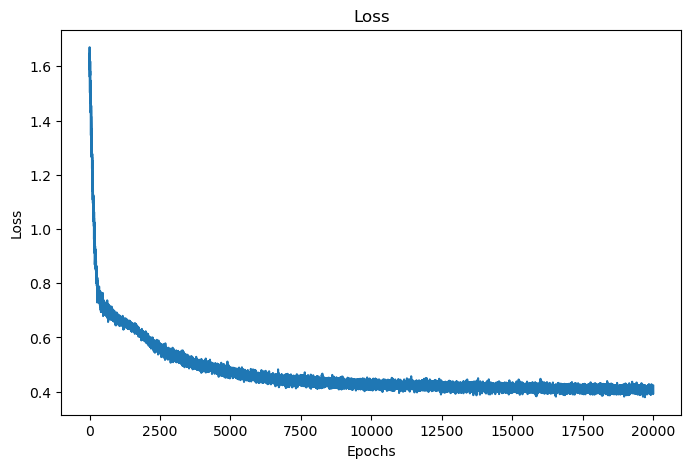

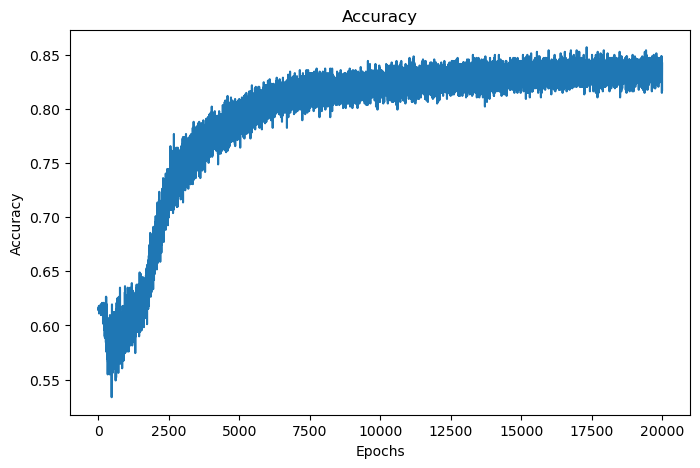

Validation Predicted correct = 80.45%
Your submission was successfully saved!


In [13]:
step = np.linspace(0, num_epochs, num_epochs)
plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

step = np.linspace(0, num_epochs, num_epochs)
plt.subplots(figsize=(8,5))
plt.plot(step, np.array(acc_values))
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

with torch.no_grad():
    best_model = NeuralNetwork(input_dim, hidden_dim1, hidden_dim2, output_dim)
    best_model.load_state_dict(torch.load("best_model.pt"))
    X = val_tensor.float()
    y = y_val_tensor.float()
    outputs = best_model(X)
    acc = get_accuracy(outputs, y_val)
    print("Validation Predicted correct = {pred:3.2f}%".format(pred = acc * 100))

    test_tensor = torch.tensor(test_proc_df.values.tolist())
    predictions = best_model(test_tensor)
    predicted = np.where(predictions < 0.5, 0, 1)

    output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predicted.flatten()})
    output.to_csv('submission.csv', index=False)
    print("Your submission was successfully saved!")